Import


In [1]:
import numpy as np
import pandas as pd
df_train = pd.read_csv("train.csv", index_col=False)
df_valid = pd.read_csv("valid.csv", index_col = False)
df_test = pd.read_csv("test.csv", index_col = False)


In [2]:
df_valid = df_valid.loc[:, df_train.columns]
df_test = df_test.loc[:, df_train.columns]


Split X/Y variables


In [3]:
y_train = df_train['FraudFound_P']
x_train = df_train.drop('FraudFound_P',axis = 1)
y_valid = df_valid['FraudFound_P']
x_valid = df_valid.drop('FraudFound_P',axis = 1)
y_test = df_test['FraudFound_P']
x_test = df_test.drop('FraudFound_P',axis = 1)


Oversampling and Undersampling


In [4]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

x_train, y_train = smote_enn.fit_resample(x_train, y_train)

### Tune For Recall

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def create_model(trial):
    leaf_size = trial.suggest_int("leaf_size", 1, 50)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    p = trial.suggest_int("p",1,2)
    model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p = p)
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return metrics.recall_score(y, y_pred)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)


[I 2022-11-13 23:19:55,188] A new study created in memory with name: no-name-f6b99579-29b1-4aa3-848f-6e7bdb8d7222
[I 2022-11-13 23:19:55,927] Trial 0 finished with value: 0.6044776119402985 and parameters: {'leaf_size': 46, 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.6044776119402985.
[I 2022-11-13 23:19:56,514] Trial 1 finished with value: 0.5074626865671642 and parameters: {'leaf_size': 19, 'n_neighbors': 7, 'p': 1}. Best is trial 0 with value: 0.6044776119402985.
[I 2022-11-13 23:19:57,110] Trial 2 finished with value: 0.5895522388059702 and parameters: {'leaf_size': 38, 'n_neighbors': 5, 'p': 2}. Best is trial 0 with value: 0.6044776119402985.
[I 2022-11-13 23:19:57,488] Trial 3 finished with value: 0.6940298507462687 and parameters: {'leaf_size': 3, 'n_neighbors': 17, 'p': 2}. Best is trial 3 with value: 0.6940298507462687.
[I 2022-11-13 23:19:58,200] Trial 4 finished with value: 0.5298507462686567 and parameters: {'leaf_size': 19, 'n_neighbors': 9, 'p': 1}. Best is 

In [7]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))
print(metrics.recall_score(y_valid,y_pred))
print(study.best_trial.params)

              precision    recall  f1-score   support

           0     0.9684    0.4890    0.6498      2131
           1     0.0841    0.7463    0.1512       134

    accuracy                         0.5042      2265
   macro avg     0.5263    0.6176    0.4005      2265
weighted avg     0.9161    0.5042    0.6203      2265

0.746268656716418
{'leaf_size': 11, 'n_neighbors': 29, 'p': 2}


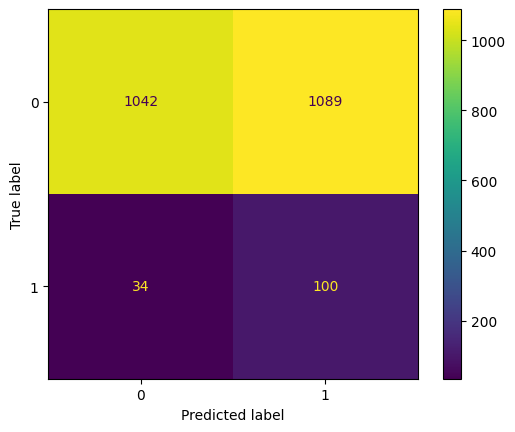

In [8]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Tune For Fbeta

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def create_model(trial):
    leaf_size = trial.suggest_int("leaf_size", 1, 50)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    p = trial.suggest_int("p",1,2)
    model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p = p)
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return metrics.fbeta_score(y, y_pred, beta = 2)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)




[I 2022-11-16 09:53:22,579] A new study created in memory with name: no-name-7a0cbc5b-2caf-4ede-8a59-7da1220e786c
[I 2022-11-16 09:53:23,197] Trial 0 finished with value: 0.30413625304136255 and parameters: {'leaf_size': 39, 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.30413625304136255.
[I 2022-11-16 09:53:23,795] Trial 1 finished with value: 0.3304484657749803 and parameters: {'leaf_size': 27, 'n_neighbors': 24, 'p': 1}. Best is trial 1 with value: 0.3304484657749803.
[I 2022-11-16 09:53:24,446] Trial 2 finished with value: 0.32006245120999216 and parameters: {'leaf_size': 13, 'n_neighbors': 19, 'p': 1}. Best is trial 1 with value: 0.3304484657749803.
[I 2022-11-16 09:53:24,796] Trial 3 finished with value: 0.2898550724637681 and parameters: {'leaf_size': 29, 'n_neighbors': 29, 'p': 2}. Best is trial 1 with value: 0.3304484657749803.
[I 2022-11-16 09:53:25,403] Trial 4 finished with value: 0.32006245120999216 and parameters: {'leaf_size': 22, 'n_neighbors': 19, 'p': 1}. 

In [7]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))
print(metrics.fbeta_score(y_valid,y_pred, beta = 2))
print(study.best_trial.params)


              precision    recall  f1-score   support

           0     0.9697    0.6748    0.7958      2131
           1     0.1138    0.6642    0.1943       134

    accuracy                         0.6742      2265
   macro avg     0.5417    0.6695    0.4951      2265
weighted avg     0.9190    0.6742    0.7602      2265

0.3376327769347496
{'leaf_size': 48, 'n_neighbors': 25, 'p': 1}


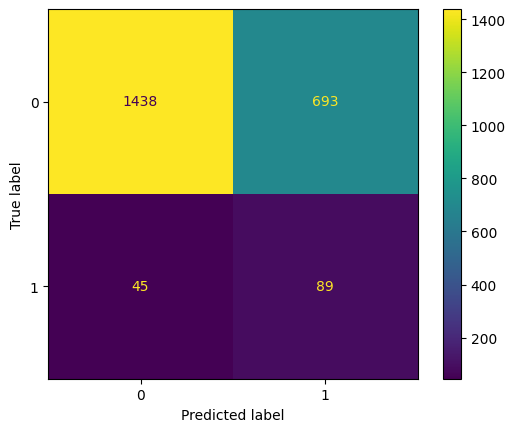

In [7]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [8]:
knn = best_model
import shap
# Initialize model
f = lambda x: knn.predict_proba(x)[:,1]
med = x_train.median().values.reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_test.iloc[0:1000,:])


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


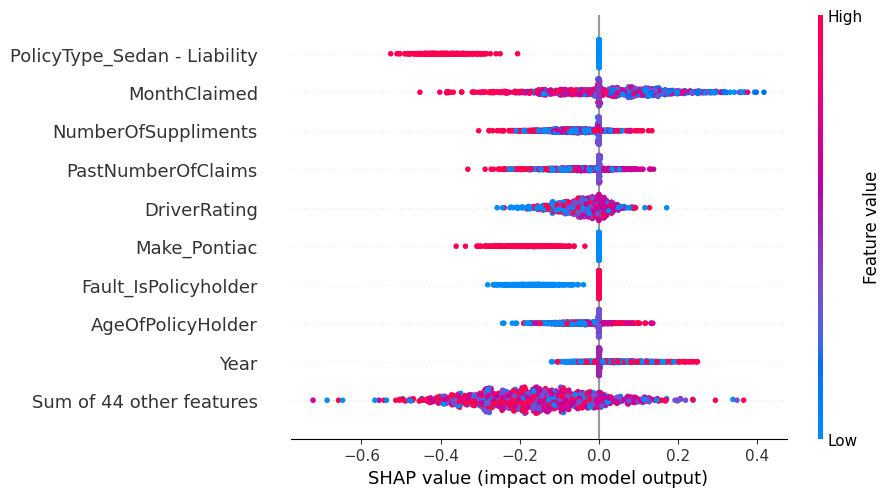

In [9]:
shap.plots.beeswarm(shap_values)


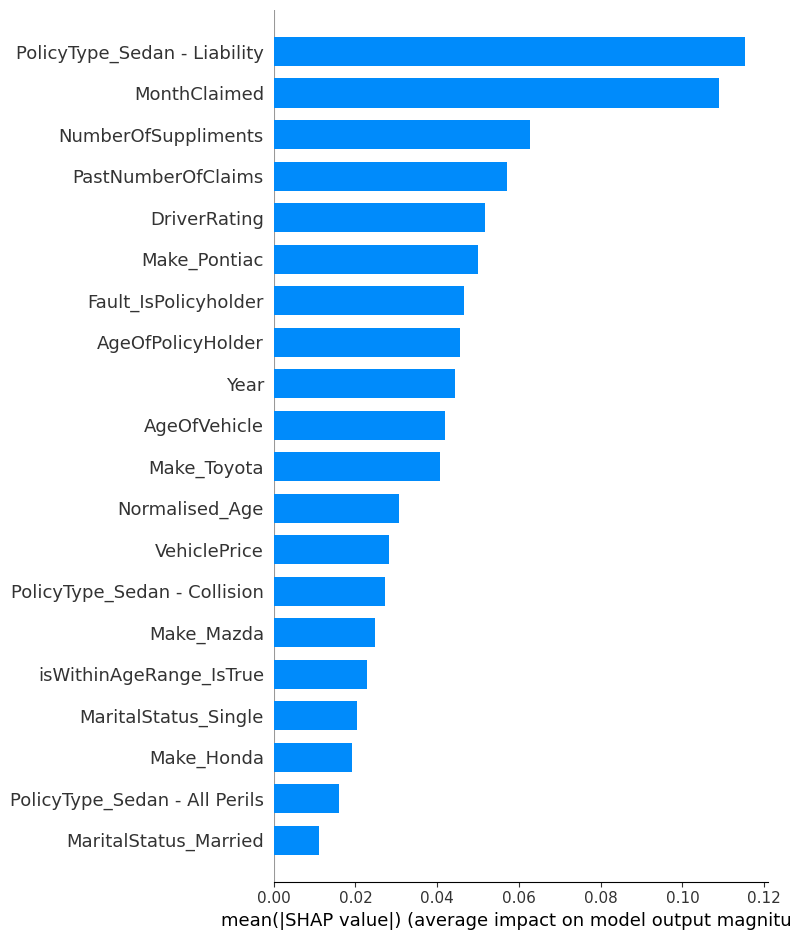

In [10]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns)